In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pathlib import Path
import warnings
import psycopg2
from sqlalchemy import create_engine
warnings.filterwarnings('ignore')
import sys
import pickle
from pprint import pprint
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
from scipy.stats import chi2_contingency 
sys.path.insert(0, os.path.realpath('..\..\src'))
from database.database_config import DB_NAME, DB_HOST, DB_USER, DB_PASSWORD

In [2]:
#testing connecting to database and getting back data
db = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}/{DB_NAME}")
conn = db.connect()

In [3]:
SQL = """
select
	match_id,
	mf.date_id,
	mf.venue_id,
	mf.referee_id,
	home_team_id as home_id,
	away_team_id as away_id,
	attendance,
    match_week,
	xg_home,
	xg_away,
	home_goal,
	away_goal,
	home_captain_name,
	away_captain_name,
	home_formation,
	away_formation,
	home_possession,
	away_possession,
	home_shots,
	home_shots_on_target,
	home_distance,
	home_freekicks,
	home_penalty_kicks,
	home_touches,
	home_touches_att_pen,
	home_touches_def_pen,
	home_touches_def_third,
	home_touches_mid_third,
	home_touches_att_third,
	home_touches_live,
	home_dribbles_success,
	home_dribbles_att,
	home_dribbles_players_number,
	home_dribbles_megs,
	home_carries,
	home_carries_tot_dist,
	home_carries_prog_dist,
	home_carries_prog,
	home_carries_one_third,
	home_carries_cpa,
	home_carries_miss,
	home_carries_dis,
	home_receiving_target,
	home_receiving_rec,
	home_receiving_prog,
	away_shots,
	away_shots_on_target,
	away_distance,
	away_freekicks,
	away_penalty_kicks,
	away_touches,
	away_touches_att_pen,
	away_touches_def_pen,
	away_touches_def_third,
	away_touches_mid_third,
	away_touches_att_third,
	away_touches_live,
	away_dribbles_success,
	away_dribbles_att,
	away_dribbles_players_number,
	away_dribbles_megs,
	away_carries,
	away_carries_tot_dist,
	away_carries_prog_dist,
	away_carries_prog,
	away_carries_one_third,
	away_carries_cpa,
	away_carries_miss,
	away_carries_dis,
	away_receiving_target,
	away_receiving_rec,
	away_receiving_prog,
	match_result,
	ht.team_name as home_team,
	aw.team_name as away_team,
	md."_date_",
	md."_time_" ,
	md."_day_",
	extract(MONTH from md."_date_") AS month,
	extract(DAY from md."_date_") AS day_of_month,
	extract(DOW from md."_date_") AS day_of_week,
	extract(YEAR from md."_date_") AS year,
	extract(HOUR from md."_time_") AS hour,
	extract(MINUTE from md."_time_") AS minute,
    extract(SECOND from md."_time_") AS second,
	mr.referee_name,
	mv.venue_name
from
	laliga_wh.match_facts mf
inner join laliga_wh.match_teams ht 
on
	ht.team_id = mf.home_team_id
inner join laliga_wh.match_teams aw 
on
	aw.team_id = mf.away_team_id
inner join laliga_wh.match_dates md 
on
	md.date_id = mf.date_id
inner join laliga_wh.match_referees mr 
on
	mr.referee_id = mf.referee_id
inner join laliga_wh.match_venues mv 
on
	mv.venue_id = mf.venue_id
"""

In [4]:
match_df = pd.read_sql(SQL, con=conn)
match_df.head()

,match_id,date_id,venue_id,referee_id,home_id,away_id,attendance,match_week,xg_home,xg_away,...,_day_,month,day_of_month,day_of_week,year,hour,minute,second,referee_name,venue_name
0,1,1,13,22,17,1,9231.0,1,1.4,1.2,...,Fri,8.0,18.0,5.0,2017.0,20.0,15.0,0.0,José Munuera,Estadio Municipal de Butarque
1,2,2,25,18,26,16,35971.0,1,1.9,0.3,...,Fri,8.0,18.0,5.0,2017.0,22.0,15.0,0.0,Jesús Gil,Estadio de Mestalla
2,3,3,22,7,6,24,16961.0,1,1.6,2.4,...,Sat,8.0,19.0,6.0,2017.0,18.0,15.0,0.0,Antonio Matéu Lahoz,Estadio de Balaídos
3,4,4,3,24,12,3,11511.0,1,2.1,0.8,...,Sat,8.0,19.0,6.0,2017.0,20.0,15.0,0.0,Juan Martínez,Estadi Municipal de Montilivi
4,5,5,18,4,25,10,30487.0,1,2.1,1.1,...,Sat,8.0,19.0,6.0,2017.0,22.0,15.0,0.0,Alejandro Hernández,Estadio Ramón Sánchez Pizjuán


# Preprocess

In [5]:
# Drop id columns
match_results = match_df.iloc[:,6:]

In [6]:
for i,v in match_results.dtypes.iteritems():
    print(i, v)

attendance float64
match_week int64
xg_home float64
xg_away float64
home_goal int64
away_goal int64
home_captain_name object
away_captain_name object
home_formation object
away_formation object
home_possession float64
away_possession float64
home_shots int64
home_shots_on_target int64
home_distance float64
home_freekicks int64
home_penalty_kicks int64
home_touches int64
home_touches_att_pen int64
home_touches_def_pen int64
home_touches_def_third int64
home_touches_mid_third int64
home_touches_att_third int64
home_touches_live int64
home_dribbles_success int64
home_dribbles_att int64
home_dribbles_players_number int64
home_dribbles_megs int64
home_carries int64
home_carries_tot_dist int64
home_carries_prog_dist int64
home_carries_prog float64
home_carries_one_third float64
home_carries_cpa float64
home_carries_miss int64
home_carries_dis int64
home_receiving_target int64
home_receiving_rec int64
home_receiving_prog int64
away_shots int64
away_shots_on_target int64
away_distance float64


In [7]:
# Fix data types for certain columns
match_results['attendance'] = match_results['attendance'].astype(pd.Int64Dtype())
match_results['_date_'] = pd.to_datetime(match_results['_date_'])
match_results['month'] = match_results['month'].astype('int')
match_results['day_of_month'] = match_results['day_of_month'].astype('int')
match_results['day_of_week'] = match_results['day_of_week'].astype('int')
match_results['year'] = match_results['year'].astype('int')
match_results['hour'] = match_results['hour'].astype('int')
match_results['minute'] = match_results['minute'].astype('int')
match_results['second'] = match_results['second'].astype('int')
match_results.drop('_day_', axis = 1, inplace = True) # Not needed as we numerically created a day of week column

In [8]:
match_results['home_formation'].value_counts()

4-4-2        636
4-2-3-1      363
4-3-3        273
4-1-4-1      144
3-5-2        125
3-4-3         89
4-4-2◆        62
4-2-2-2       56
4-4-1-1       41
4-5-1         22
3-2-2-2-1     14
4-3-2-1       12
3-4-1-2       11
3-1-4-2        8
3-3-2-2        7
3-2-3-2        5
4-3-1-2◆       5
3-2-2-1-2      4
3-5-1-1        4
4-3-3◆         3
4-2-2-1-1      3
5-3-2          2
5-4-1          2
4-1-3-2        1
4-1-3-2◆       1
4-3-1-2        1
3-1-4-1-1      1
4-2-3-1◆       1
4-1-2-3        1
3-2-2-3        1
3-2-1-2-2      1
3-4-3◆         1
Name: home_formation, dtype: int64

In [9]:
# Clean up formations
match_results['home_formation'] = match_results['home_formation'].replace({'4-4-2◆': '4-4-2', '4-3-1-2◆':'4-3-1-2', '4-3-3◆':'4-3-3', '4-1-3-2◆':'4-1-3-2',
                                         '4-2-3-1◆':'4-2-3-1', '3-4-3◆':'3-4-3'})
match_results['away_formation'] = match_results['away_formation'].replace({'4-4-2◆': '4-4-2', '4-3-1-2◆':'4-3-1-2', '4-3-3◆':'4-3-3', '4-1-3-2◆':'4-1-3-2',
                                         '4-2-3-1◆':'4-2-3-1', '3-4-3◆':'3-4-3', '4-3-2-1◆':'4-3-2-1'})

# Time Frame of Our Data

In [10]:
print('Start Date: ', min(match_results._date_.dt.date))
print('End Date: ', max(match_results._date_.dt.date))

Start Date:  2017-08-18
End Date:  2022-05-22


We have data from August 2017 to May 2022. This encompasses the 2017-2018 to the 2021-2022 season

In [11]:
def calc_missing_values(df):
    """
    Calculate percentage of NAs in dataframe
    :param df:
    :return:
    """
    num = df.isnull().sum()
    length = len(df)
    print("Percent NA")
    print(round(num/length, 2))

def calc_outliers(df):
    """
    Calculate the IQR to detect outliers.
    :param df
    :return: list of outliers counted per column
    """
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3 - q1
    print("Outliers Count")
    print(((df < (q1 - 1.5 * iqr)) | (df > (q3 + 1.5 * iqr))).sum())

In [12]:
# Count number of missing values
for i, v in match_results.isna().sum().iteritems():
    print(i + '\t' + str(v))

attendance	488
match_week	0
xg_home	0
xg_away	0
home_goal	0
away_goal	0
home_captain_name	0
away_captain_name	0
home_formation	0
away_formation	0
home_possession	0
away_possession	0
home_shots	0
home_shots_on_target	0
home_distance	0
home_freekicks	0
home_penalty_kicks	0
home_touches	0
home_touches_att_pen	0
home_touches_def_pen	0
home_touches_def_third	0
home_touches_mid_third	0
home_touches_att_third	0
home_touches_live	0
home_dribbles_success	0
home_dribbles_att	0
home_dribbles_players_number	0
home_dribbles_megs	0
home_carries	0
home_carries_tot_dist	0
home_carries_prog_dist	0
home_carries_prog	1
home_carries_one_third	1
home_carries_cpa	1
home_carries_miss	0
home_carries_dis	0
home_receiving_target	0
home_receiving_rec	0
home_receiving_prog	0
away_shots	0
away_shots_on_target	0
away_distance	2
away_freekicks	0
away_penalty_kicks	0
away_touches	0
away_touches_att_pen	0
away_touches_def_pen	0
away_touches_def_third	0
away_touches_mid_third	0
away_touches_att_third	0
away_touches_liv

In [13]:
# Drop attendance. We have MCAR data here and not recommended to keep it
# Fill other columns with 1 misisng value with median
match_results.drop('attendance', axis = 1, inplace = True)
match_results[['home_carries_prog', 'home_carries_one_third', 'home_carries_cpa', 'away_carries_prog', 'away_carries_one_third', 'away_carries_cpa', 'away_distance']] = match_results[['home_carries_prog', 'home_carries_one_third', 'home_carries_cpa', 'away_carries_prog', 'away_carries_one_third', 'away_carries_cpa', 'away_distance']].fillna(match_results[['home_carries_prog', 'home_carries_one_third', 'home_carries_cpa', 'away_carries_prog', 'away_carries_one_third', 'away_carries_cpa', 'away_distance']].median())

In [14]:
# Count number of missing values
for i, v in match_results.isna().sum().iteritems():
    print(i + '\t' + str(v))

match_week	0
xg_home	0
xg_away	0
home_goal	0
away_goal	0
home_captain_name	0
away_captain_name	0
home_formation	0
away_formation	0
home_possession	0
away_possession	0
home_shots	0
home_shots_on_target	0
home_distance	0
home_freekicks	0
home_penalty_kicks	0
home_touches	0
home_touches_att_pen	0
home_touches_def_pen	0
home_touches_def_third	0
home_touches_mid_third	0
home_touches_att_third	0
home_touches_live	0
home_dribbles_success	0
home_dribbles_att	0
home_dribbles_players_number	0
home_dribbles_megs	0
home_carries	0
home_carries_tot_dist	0
home_carries_prog_dist	0
home_carries_prog	0
home_carries_one_third	0
home_carries_cpa	0
home_carries_miss	0
home_carries_dis	0
home_receiving_target	0
home_receiving_rec	0
home_receiving_prog	0
away_shots	0
away_shots_on_target	0
away_distance	0
away_freekicks	0
away_penalty_kicks	0
away_touches	0
away_touches_att_pen	0
away_touches_def_pen	0
away_touches_def_third	0
away_touches_mid_third	0
away_touches_att_third	0
away_touches_live	0
away_dribbl

In [15]:
match_results.head()

,match_week,xg_home,xg_away,home_goal,away_goal,home_captain_name,away_captain_name,home_formation,away_formation,home_possession,...,_time_,month,day_of_month,day_of_week,year,hour,minute,second,referee_name,venue_name
0,1,1.4,1.2,1,0,Martín Mantovani,Manu García,4-2-3-1,4-4-2,54.0,...,20:15:00,8,18,5,2017,20,15,0,José Munuera,Estadio Municipal de Butarque
1,1,1.9,0.3,1,0,Daniel Parejo,Jonathan Viera,4-4-2,4-5-1,48.0,...,22:15:00,8,18,5,2017,22,15,0,Jesús Gil,Estadio de Mestalla
2,1,1.6,2.4,2,3,Hugo Mallo,Xabi Prieto,4-3-3,4-3-3,53.0,...,18:15:00,8,19,6,2017,18,15,0,Antonio Matéu Lahoz,Estadio de Balaídos
3,1,2.1,0.8,2,2,Álex Granell,Gabi,3-4-3,4-4-2,53.0,...,20:15:00,8,19,6,2017,20,15,0,Juan Martínez,Estadi Municipal de Montilivi
4,1,2.1,1.1,1,1,Jesús Navas,Gerard Moreno,4-1-4-1,4-4-2,62.0,...,22:15:00,8,19,6,2017,22,15,0,Alejandro Hernández,Estadio Ramón Sánchez Pizjuán


In [16]:
# One hot encode
match_results_encode = pd.get_dummies(match_results, columns = ['home_captain_name', 'away_captain_name', 'home_formation', 'away_formation',
                                                                'home_team', 'away_team', 'referee_name', 'venue_name'])

In [17]:
match_results_encode.head()

,match_week,xg_home,xg_away,home_goal,away_goal,home_possession,away_possession,home_shots,home_shots_on_target,home_distance,...,venue_name_Estadio Wanda Metropolitano,venue_name_Estadio de Balaídos,venue_name_Estadio de Gran Canaria,venue_name_Estadio de Mendizorroza,venue_name_Estadio de Mestalla,venue_name_Estadio de la Cerámica,venue_name_Estadio del Rayo Vallecano,venue_name_Iberostar Estadi,venue_name_RCDE Stadium,venue_name_San Mamés
0,1,1.4,1.2,1,0,54.0,46.0,14,3,20.8,...,0,0,0,0,0,0,0,0,0,0
1,1,1.9,0.3,1,0,48.0,52.0,22,6,15.9,...,0,0,0,0,1,0,0,0,0,0
2,1,1.6,2.4,2,3,53.0,47.0,16,5,16.9,...,0,1,0,0,0,0,0,0,0,0
3,1,2.1,0.8,2,2,53.0,47.0,14,6,16.8,...,0,0,0,0,0,0,0,0,0,0
4,1,2.1,1.1,1,1,62.0,38.0,9,4,11.6,...,0,0,0,0,0,0,0,0,0,0


In [18]:
for i,v in match_results_encode.dtypes.iteritems():
    print(i, v)

match_week int64
xg_home float64
xg_away float64
home_goal int64
away_goal int64
home_possession float64
away_possession float64
home_shots int64
home_shots_on_target int64
home_distance float64
home_freekicks int64
home_penalty_kicks int64
home_touches int64
home_touches_att_pen int64
home_touches_def_pen int64
home_touches_def_third int64
home_touches_mid_third int64
home_touches_att_third int64
home_touches_live int64
home_dribbles_success int64
home_dribbles_att int64
home_dribbles_players_number int64
home_dribbles_megs int64
home_carries int64
home_carries_tot_dist int64
home_carries_prog_dist int64
home_carries_prog float64
home_carries_one_third float64
home_carries_cpa float64
home_carries_miss int64
home_carries_dis int64
home_receiving_target int64
home_receiving_rec int64
home_receiving_prog int64
away_shots int64
away_shots_on_target int64
away_distance float64
away_freekicks int64
away_penalty_kicks int64
away_touches int64
away_touches_att_pen int64
away_touches_def_pen 

venue_name_Estadio Benito Villamarín uint8
venue_name_Estadio Ciudad de Valencia uint8
venue_name_Estadio El Alcoraz uint8
venue_name_Estadio El Sadar uint8
venue_name_Estadio La Rosaleda uint8
venue_name_Estadio Manuel Martínez Valero uint8
venue_name_Estadio Municipal José Zorrilla uint8
venue_name_Estadio Municipal de Anoeta uint8
venue_name_Estadio Municipal de Butarque uint8
venue_name_Estadio Municipal de Ipurúa uint8
venue_name_Estadio Municipal de Riazor uint8
venue_name_Estadio Nuevo Los Cármenes uint8
venue_name_Estadio Nuevo Mirandilla uint8
venue_name_Estadio Ramón Sánchez Pizjuán uint8
venue_name_Estadio San Mamés uint8
venue_name_Estadio Santiago Bernabéu uint8
venue_name_Estadio Wanda Metropolitano uint8
venue_name_Estadio de Balaídos uint8
venue_name_Estadio de Gran Canaria uint8
venue_name_Estadio de Mendizorroza uint8
venue_name_Estadio de Mestalla uint8
venue_name_Estadio de la Cerámica uint8
venue_name_Estadio del Rayo Vallecano uint8
venue_name_Iberostar Estadi uin

# Data Exploration

[Text(0, 0, '844'), Text(0, 0, '535'), Text(0, 0, '521')]

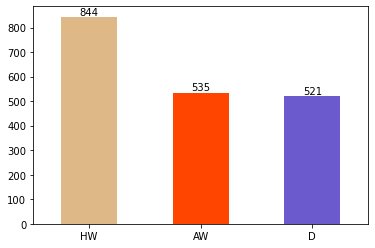

In [19]:
ax = match_results_encode['match_result'].value_counts().plot(kind = 'bar', color = ['burlywood', 'orangered', 'slateblue'], rot =0)
ax.plot()
ax.bar_label(ax.containers[0])

In [20]:
match_results_encode.groupby('match_result')['match_result'].count()

match_result
AW    535
D     521
HW    844
Name: match_result, dtype: int64

In [21]:
# get all records with El Clasico
clasico_matches = match_results_encode[((match_results_encode['home_team_Barcelona'] == 1) & (match_results_encode['away_team_Real Madrid'] == 1)) |
                                       ((match_results_encode['home_team_Real Madrid'] == 1) & (match_results_encode['away_team_Barcelona'] == 1))]

In [22]:
clasico_matches

,match_week,xg_home,xg_away,home_goal,away_goal,home_possession,away_possession,home_shots,home_shots_on_target,home_distance,...,venue_name_Estadio Wanda Metropolitano,venue_name_Estadio de Balaídos,venue_name_Estadio de Gran Canaria,venue_name_Estadio de Mendizorroza,venue_name_Estadio de Mestalla,venue_name_Estadio de la Cerámica,venue_name_Estadio del Rayo Vallecano,venue_name_Iberostar Estadi,venue_name_RCDE Stadium,venue_name_San Mamés
166,17,1.0,2.5,0,3,45.0,55.0,13,5,15.7,...,0,0,0,0,0,0,0,0,0,0
356,36,1.3,2.1,2,2,50.0,50.0,11,4,15.0,...,0,0,0,0,0,0,0,0,0,0
477,10,3.0,2.1,5,1,53.0,47.0,12,7,16.0,...,0,0,0,0,0,0,0,0,0,0
634,26,1.1,1.6,0,1,49.0,51.0,18,3,17.5,...,0,0,0,0,0,0,0,0,0,0
929,10,0.9,0.9,0,0,51.0,49.0,9,1,16.5,...,0,0,0,0,0,0,0,0,0,0
1018,26,1.1,1.0,2,0,44.0,56.0,13,4,16.3,...,0,0,0,0,0,0,0,0,0,0
1194,7,1.1,3.3,1,3,52.0,48.0,10,4,16.8,...,0,0,0,0,0,0,0,0,0,0
1434,30,1.6,1.6,2,1,32.0,68.0,14,3,17.5,...,0,0,0,0,0,0,0,0,0,0
1612,10,1.7,1.1,1,2,51.0,49.0,12,2,14.7,...,0,0,0,0,0,0,0,0,0,0
1808,29,0.8,3.5,0,4,40.0,60.0,14,4,19.9,...,0,0,0,0,0,0,0,0,0,0


In [23]:
clasico_matches['home_team_Barcelona'].value_counts()

0    5
1    5
Name: home_team_Barcelona, dtype: int64

In [24]:
def create_clasico_result(row):
    if row.match_result == 'HW' and row['home_team_Barcelona'] == 1:
        return 'Barcelona Win'
    elif row.match_result == 'AW' and row['away_team_Barcelona'] == 1:
        return 'Barcelona Win'
    elif row.match_result == 'HW' and row['home_team_Real Madrid'] == 1:
        return 'Real Madrid Win'
    elif row.match_result == 'AW' and row['away_team_Real Madrid'] == 1:
        return 'Real Madrid Win'
    else:
        return 'Draw'
    

In [25]:
clasico_matches['clasico_result'] = clasico_matches.apply(create_clasico_result, axis =1)

[Text(0, 0, '4'), Text(0, 0, '4'), Text(0, 0, '2')]

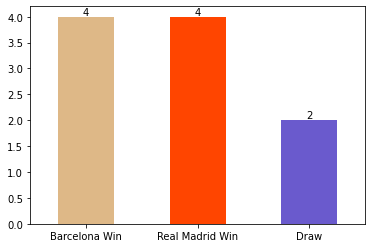

In [26]:
ax = clasico_matches['clasico_result'].value_counts().plot(kind = 'bar', color = ['burlywood', 'orangered', 'slateblue'], rot = 0)
ax.plot()
ax.bar_label(ax.containers[0])

In [27]:
#Select all our numerical columns
numerical_columns = match_results_encode.select_dtypes(include=['Int64', 'int64', 'float64'])

In [28]:
numerical_columns

,match_week,xg_home,xg_away,home_goal,away_goal,home_possession,away_possession,home_shots,home_shots_on_target,home_distance,...,away_carries_tot_dist,away_carries_prog_dist,away_carries_prog,away_carries_one_third,away_carries_cpa,away_carries_miss,away_carries_dis,away_receiving_target,away_receiving_rec,away_receiving_prog
0,1,1.4,1.2,1,0,54.0,46.0,14,3,20.8,...,1542,758,21.0,5.0,1.0,15,15,309,250,250
1,1,1.9,0.3,1,0,48.0,52.0,22,6,15.9,...,2691,1439,52.0,15.0,2.0,15,12,499,451,451
2,1,1.6,2.4,2,3,53.0,47.0,16,5,16.9,...,1896,1013,30.0,10.0,3.0,14,7,419,352,352
3,1,2.1,0.8,2,2,53.0,47.0,14,6,16.8,...,1892,1169,44.0,15.0,3.0,5,8,406,347,347
4,1,2.1,1.1,1,1,62.0,38.0,9,4,11.6,...,1531,755,32.0,17.0,3.0,5,12,401,297,297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895,38,2.0,0.4,0,0,40.0,60.0,14,5,17.9,...,2783,1348,50.0,18.0,5.0,15,13,487,466,466
1896,38,0.8,1.3,0,2,62.0,38.0,11,1,14.6,...,1164,595,27.0,9.0,4.0,14,5,270,211,211
1897,38,0.7,0.7,0,2,70.0,30.0,15,3,19.1,...,1158,503,14.0,2.0,4.0,12,5,300,254,254
1898,38,2.3,0.8,1,2,61.0,39.0,13,3,16.1,...,1390,530,20.0,6.0,0.0,19,11,363,281,281


In [29]:
for i in numerical_columns:
    print(i)

match_week
xg_home
xg_away
home_goal
away_goal
home_possession
away_possession
home_shots
home_shots_on_target
home_distance
home_freekicks
home_penalty_kicks
home_touches
home_touches_att_pen
home_touches_def_pen
home_touches_def_third
home_touches_mid_third
home_touches_att_third
home_touches_live
home_dribbles_success
home_dribbles_att
home_dribbles_players_number
home_dribbles_megs
home_carries
home_carries_tot_dist
home_carries_prog_dist
home_carries_prog
home_carries_one_third
home_carries_cpa
home_carries_miss
home_carries_dis
home_receiving_target
home_receiving_rec
home_receiving_prog
away_shots
away_shots_on_target
away_distance
away_freekicks
away_penalty_kicks
away_touches
away_touches_att_pen
away_touches_def_pen
away_touches_def_third
away_touches_mid_third
away_touches_att_third
away_touches_live
away_dribbles_success
away_dribbles_att
away_dribbles_players_number
away_dribbles_megs
away_carries
away_carries_tot_dist
away_carries_prog_dist
away_carries_prog
away_carries_

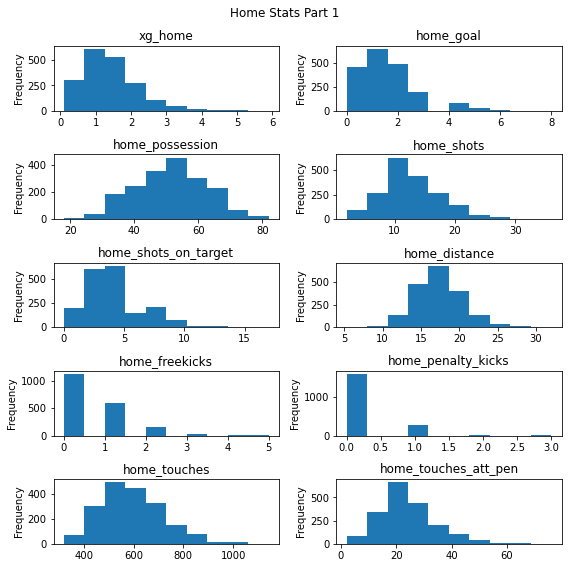

In [30]:
fig1, ax1 = plt.subplots(nrows=5, ncols= 2,figsize=(8, 8))
numerical_columns['xg_home'].plot.hist(ax =ax1[0,0], title = 'xg_home')
numerical_columns['home_goal'].plot.hist(ax =ax1[0,1], title = 'home_goal')
numerical_columns['home_possession'].plot.hist(ax =ax1[1,0], title = 'home_possession')
numerical_columns['home_shots'].plot.hist(ax =ax1[1,1], title = 'home_shots')
numerical_columns['home_shots_on_target'].plot.hist(ax =ax1[2,0], title = 'home_shots_on_target')
numerical_columns['home_distance'].plot.hist(ax =ax1[2,1], title = 'home_distance')
numerical_columns['home_freekicks'].plot.hist(ax =ax1[3,0], title = 'home_freekicks')
numerical_columns['home_penalty_kicks'].plot.hist(ax =ax1[3,1], title = 'home_penalty_kicks')
numerical_columns['home_touches'].plot.hist(ax =ax1[4,0], title = 'home_touches')
numerical_columns['home_touches_att_pen'].plot.hist(ax =ax1[4,1], title = 'home_touches_att_pen')

plt.suptitle('Home Stats Part 1')
plt.tight_layout()
plt.show()

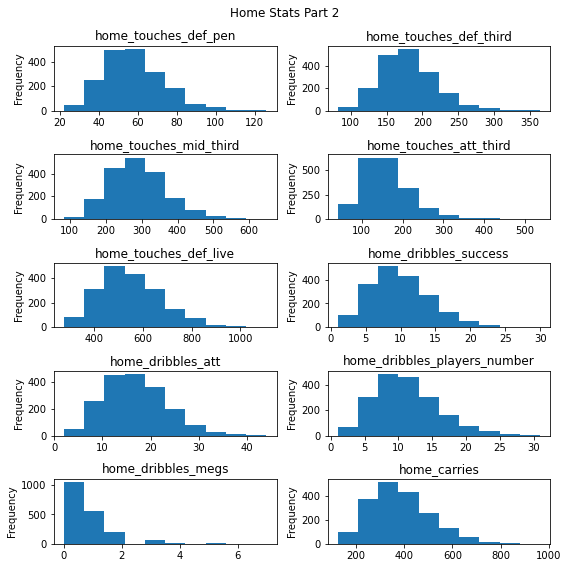

In [31]:
fig2, ax2 = plt.subplots(nrows=5, ncols= 2,figsize=(8, 8))
numerical_columns['home_touches_def_pen'].plot.hist(ax =ax2[0,0], title = 'home_touches_def_pen')
numerical_columns['home_touches_def_third'].plot.hist(ax =ax2[0,1], title = 'home_touches_def_third')
numerical_columns['home_touches_mid_third'].plot.hist(ax =ax2[1,0], title = 'home_touches_mid_third')
numerical_columns['home_touches_att_third'].plot.hist(ax =ax2[1,1], title = 'home_touches_att_third')
numerical_columns['home_touches_live'].plot.hist(ax =ax2[2,0], title = 'home_touches_def_live')
numerical_columns['home_dribbles_success'].plot.hist(ax =ax2[2,1], title = 'home_dribbles_success')
numerical_columns['home_dribbles_att'].plot.hist(ax =ax2[3,0], title = 'home_dribbles_att')
numerical_columns['home_dribbles_players_number'].plot.hist(ax =ax2[3,1], title = 'home_dribbles_players_number')
numerical_columns['home_dribbles_megs'].plot.hist(ax =ax2[4,0], title = 'home_dribbles_megs')
numerical_columns['home_carries'].plot.hist(ax =ax2[4,1], title = 'home_carries')

plt.suptitle('Home Stats Part 2')
plt.tight_layout()
plt.show()

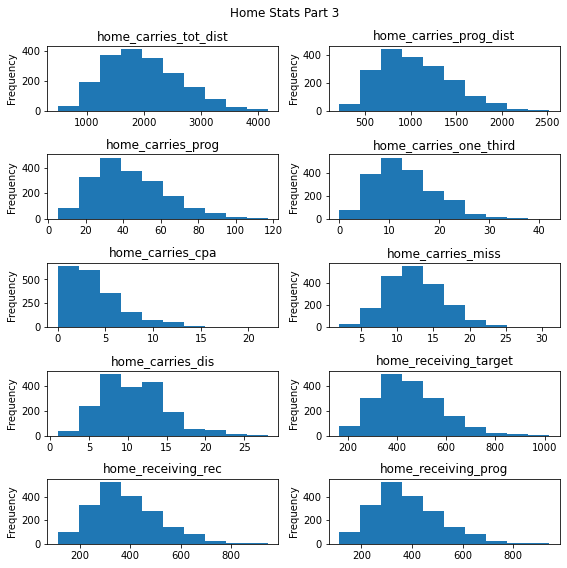

In [32]:
fig2, ax2 = plt.subplots(nrows=5, ncols= 2,figsize=(8, 8))
numerical_columns['home_carries_tot_dist'].plot.hist(ax =ax2[0,0], title = 'home_carries_tot_dist')
numerical_columns['home_carries_prog_dist'].plot.hist(ax =ax2[0,1], title = 'home_carries_prog_dist')
numerical_columns['home_carries_prog'].plot.hist(ax =ax2[1,0], title = 'home_carries_prog')
numerical_columns['home_carries_one_third'].plot.hist(ax =ax2[1,1], title = 'home_carries_one_third')
numerical_columns['home_carries_cpa'].plot.hist(ax =ax2[2,0], title = 'home_carries_cpa')
numerical_columns['home_carries_miss'].plot.hist(ax =ax2[2,1], title = 'home_carries_miss')
numerical_columns['home_carries_dis'].plot.hist(ax =ax2[3,0], title = 'home_carries_dis')
numerical_columns['home_receiving_target'].plot.hist(ax =ax2[3,1], title = 'home_receiving_target')
numerical_columns['home_receiving_rec'].plot.hist(ax =ax2[4,0], title = 'home_receiving_rec')
numerical_columns['home_receiving_prog'].plot.hist(ax =ax2[4,1], title = 'home_receiving_prog')

plt.suptitle('Home Stats Part 3')
plt.tight_layout()
plt.show()

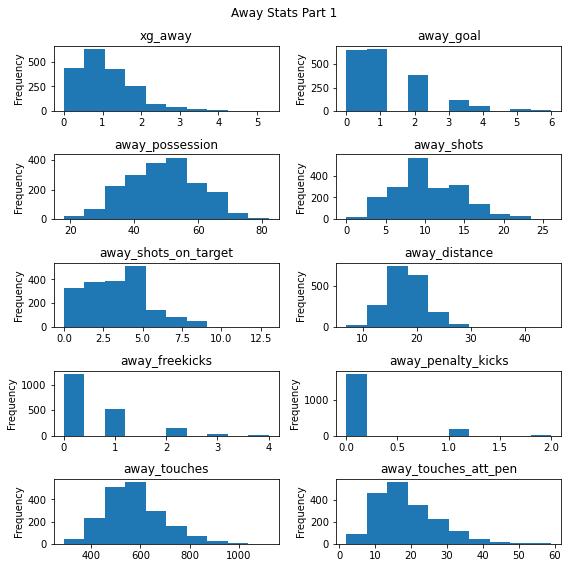

In [33]:
fig1, ax1 = plt.subplots(nrows=5, ncols= 2,figsize=(8, 8))
numerical_columns['xg_away'].plot.hist(ax =ax1[0,0], title = 'xg_away')
numerical_columns['away_goal'].plot.hist(ax =ax1[0,1], title = 'away_goal')
numerical_columns['away_possession'].plot.hist(ax =ax1[1,0], title = 'away_possession')
numerical_columns['away_shots'].plot.hist(ax =ax1[1,1], title = 'away_shots')
numerical_columns['away_shots_on_target'].plot.hist(ax =ax1[2,0], title = 'away_shots_on_target')
numerical_columns['away_distance'].plot.hist(ax =ax1[2,1], title = 'away_distance')
numerical_columns['away_freekicks'].plot.hist(ax =ax1[3,0], title = 'away_freekicks')
numerical_columns['away_penalty_kicks'].plot.hist(ax =ax1[3,1], title = 'away_penalty_kicks')
numerical_columns['away_touches'].plot.hist(ax =ax1[4,0], title = 'away_touches')
numerical_columns['away_touches_att_pen'].plot.hist(ax =ax1[4,1], title = 'away_touches_att_pen')

plt.suptitle('Away Stats Part 1')
plt.tight_layout()
plt.show()

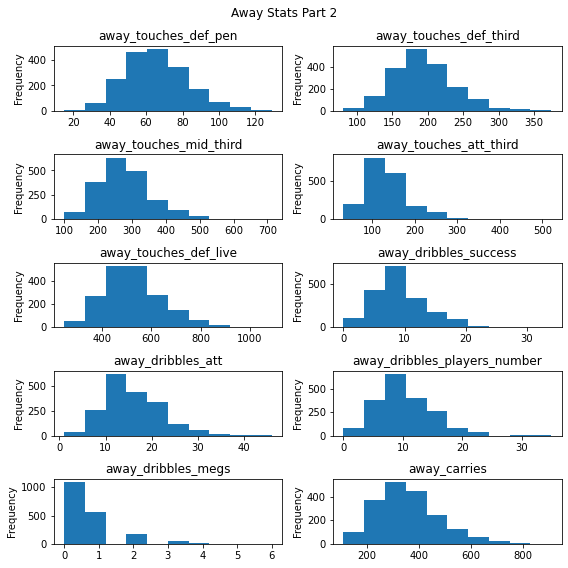

In [34]:
fig2, ax2 = plt.subplots(nrows=5, ncols= 2,figsize=(8, 8))
numerical_columns['away_touches_def_pen'].plot.hist(ax =ax2[0,0], title = 'away_touches_def_pen')
numerical_columns['away_touches_def_third'].plot.hist(ax =ax2[0,1], title = 'away_touches_def_third')
numerical_columns['away_touches_mid_third'].plot.hist(ax =ax2[1,0], title = 'away_touches_mid_third')
numerical_columns['away_touches_att_third'].plot.hist(ax =ax2[1,1], title = 'away_touches_att_third')
numerical_columns['away_touches_live'].plot.hist(ax =ax2[2,0], title = 'away_touches_def_live')
numerical_columns['away_dribbles_success'].plot.hist(ax =ax2[2,1], title = 'away_dribbles_success')
numerical_columns['away_dribbles_att'].plot.hist(ax =ax2[3,0], title = 'away_dribbles_att')
numerical_columns['away_dribbles_players_number'].plot.hist(ax =ax2[3,1], title = 'away_dribbles_players_number')
numerical_columns['away_dribbles_megs'].plot.hist(ax =ax2[4,0], title = 'away_dribbles_megs')
numerical_columns['away_carries'].plot.hist(ax =ax2[4,1], title = 'away_carries')

plt.suptitle('Away Stats Part 2')
plt.tight_layout()
plt.show()

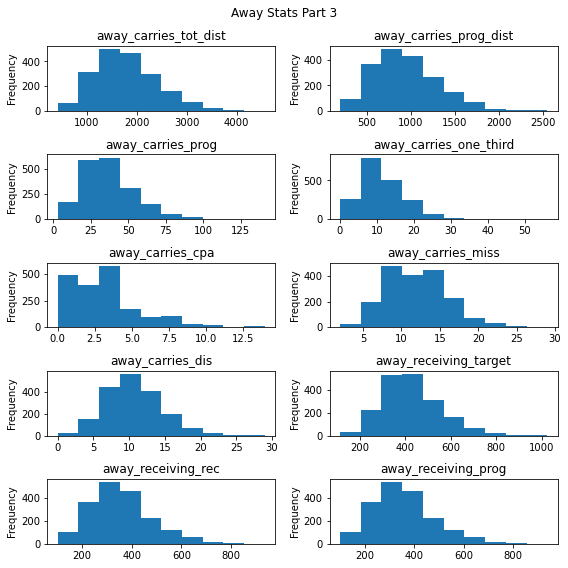

In [35]:
fig2, ax2 = plt.subplots(nrows=5, ncols= 2,figsize=(8, 8))
numerical_columns['away_carries_tot_dist'].plot.hist(ax =ax2[0,0], title = 'away_carries_tot_dist')
numerical_columns['away_carries_prog_dist'].plot.hist(ax =ax2[0,1], title = 'away_carries_prog_dist')
numerical_columns['away_carries_prog'].plot.hist(ax =ax2[1,0], title = 'away_carries_prog')
numerical_columns['away_carries_one_third'].plot.hist(ax =ax2[1,1], title = 'away_carries_one_third')
numerical_columns['away_carries_cpa'].plot.hist(ax =ax2[2,0], title = 'away_carries_cpa')
numerical_columns['away_carries_miss'].plot.hist(ax =ax2[2,1], title = 'away_carries_miss')
numerical_columns['away_carries_dis'].plot.hist(ax =ax2[3,0], title = 'away_carries_dis')
numerical_columns['away_receiving_target'].plot.hist(ax =ax2[3,1], title = 'away_receiving_target')
numerical_columns['away_receiving_rec'].plot.hist(ax =ax2[4,0], title = 'away_receiving_rec')
numerical_columns['away_receiving_prog'].plot.hist(ax =ax2[4,1], title = 'away_receiving_prog')

plt.suptitle('Away Stats Part 3')
plt.tight_layout()
plt.show()

In [36]:
pd.set_option('display.max_columns', None)
match_results_encode.head()

,match_week,xg_home,xg_away,home_goal,away_goal,home_possession,away_possession,home_shots,home_shots_on_target,home_distance,home_freekicks,home_penalty_kicks,home_touches,home_touches_att_pen,home_touches_def_pen,home_touches_def_third,home_touches_mid_third,home_touches_att_third,home_touches_live,home_dribbles_success,home_dribbles_att,home_dribbles_players_number,home_dribbles_megs,home_carries,home_carries_tot_dist,home_carries_prog_dist,home_carries_prog,home_carries_one_third,home_carries_cpa,home_carries_miss,home_carries_dis,home_receiving_target,home_receiving_rec,home_receiving_prog,away_shots,away_shots_on_target,away_distance,away_freekicks,away_penalty_kicks,away_touches,away_touches_att_pen,away_touches_def_pen,away_touches_def_third,away_touches_mid_third,away_touches_att_third,away_touches_live,away_dribbles_success,away_dribbles_att,away_dribbles_players_number,away_dribbles_megs,away_carries,away_carries_tot_dist,away_carries_prog_dist,away_carries_prog,away_carries_one_third,away_carries_cpa,away_carries_miss,away_carries_dis,away_receiving_target,away_receiving_rec,away_receiving_prog,match_result,_date_,_time_,month,day_of_month,day_of_week,year,hour,minute,second,home_captain_name_Aday,home_captain_name_Adri Embarba,home_captain_name_Adrián López,home_captain_name_Aitor Fernández,home_captain_name_Alberto Cifuentes,home_captain_name_Alberto García,home_captain_name_Alexander,home_captain_name_Alexis,home_captain_name_Alfonso Espino,home_captain_name_Ander Capa,home_captain_name_Ander Iturraspe,home_captain_name_Andrés Guardado,home_captain_name_Andrés Iniesta,home_captain_name_Antoine Griezmann,home_captain_name_Antonio Adán,home_captain_name_Antonio Raillo,home_captain_name_Aritz Elustondo,home_captain_name_Asier Illarramendi,home_captain_name_Asier Riesgo,home_captain_name_Aïssa Mandi,home_captain_name_Borja Fernández,home_captain_name_Bruno González,home_captain_name_Bruno Soriano,home_captain_name_Carlos Soler,home_captain_name_Celso Borges,home_captain_name_Coke,home_captain_name_Cristhian Stuani,home_captain_name_Cristiano Ronaldo,home_captain_name_Damián Suárez,home_captain_name_Dani García,home_captain_name_Dani Giménez,home_captain_name_Daniel Carriço,home_captain_name_Daniel Parejo,home_captain_name_David García,home_captain_name_David López,home_captain_name_David Timor,home_captain_name_David Zurutuza,home_captain_name_Diego Godín,home_captain_name_Diego López,home_captain_name_Djené,home_captain_name_Dídac Vilà,home_captain_name_Esteban Granero,home_captain_name_Fernando,home_captain_name_Fernando Pacheco,home_captain_name_Fernando Torres,home_captain_name_Fidel,home_captain_name_Gabi,home_captain_name_Gabriel,home_captain_name_Gabriel Paulista,home_captain_name_Geoffrey Kondogbia,home_captain_name_Gerard Moreno,home_captain_name_Gerard Piqué,home_captain_name_Germán Sánchez,home_captain_name_Gonzalo Escalante,home_captain_name_Gonzalo Melero,home_captain_name_Gonzalo Verdú,home_captain_name_Gustavo Cabral,home_captain_name_Hugo Mallo,home_captain_name_Iago Aspas,home_captain_name_Igor Zubeldia,home_captain_name_Iker Muniain,home_captain_name_Ivan Rakitić,home_captain_name_Iván Marcone,home_captain_name_Iván Ramis,home_captain_name_Jaime Mata,home_captain_name_Jan Oblak,home_captain_name_Jaume Costa,home_captain_name_Jaume Doménech,home_captain_name_Javi García,home_captain_name_Javi López,home_captain_name_Javi Moyano,home_captain_name_Jesús Navas,home_captain_name_Joan Jordán,home_captain_name_Joaquín,home_captain_name_Jon Ander Garrido,home_captain_name_Jon Ander Serantes,home_captain_name_Jonathan Viera,home_captain_name_Jordi Alba,home_captain_name_Jordi Amat,home_captain_name_Jordi Masip,home_captain_name_Jorge Molina,home_captain_name_Jorge Pulido,home_captain_name_Joseba Zaldúa,home_captain_name_José Luis Gayà,home_captain_name_José Luis Morales,home_captain_name_José Mari,home_captain_name_Juanfran,home_captain_name_Karim Benzema,home_captain_name_Kike,home_captain_name_Koke,home_c

In [37]:
cols=match_results_encode.drop(columns='match_result').columns

In [38]:
category_cols = list(set(cols) - set(numerical_columns))
count1=0
for i in category_cols:
    count1+=1
print(count1)    

515


In [56]:
count = 0
for i in category_cols:
    chisqt = pd.crosstab(match_results_encode[i], match_results_encode['match_result'], margins = True)
    value = np.array([chisqt.iloc[0].values,
                  chisqt.iloc[1].values])
    stat, p, dof = chi2_contingency(value)[0:3]
    if p < 0.05:
        print(i + "\t"  + "\t" + str(p))
        count+=1
print("Count of columns = " + str(count))    
    

away_captain_name_Karim Benzema		1.9492011281455906e-08
home_captain_name_Lionel Messi		8.655974457668748e-05
venue_name_Camp Nou		1.07773960907413e-07
away_team_Alavés		0.0010747635783238476
away_captain_name_Lionel Messi		8.381019523179344e-08
away_captain_name_David López		0.019904961197261508
home_captain_name_Daniel Parejo		0.02815281502504988
home_team_Valladolid		0.011041610799023108
home_captain_name_Míchel		0.026644566144895434
home_captain_name_Sergio Ramos		0.005202151479418872
home_captain_name_Kike		0.011137151164567465
away_formation_4-3-3		0.00014099098838058242
away_team_Málaga		0.006101360667961852
away_captain_name_Gabi		0.02978111682412344
away_team_Real Madrid		8.26554022615819e-10
home_captain_name_Markel Susaeta		0.004314987105289339
venue_name_Estadio de Mestalla		0.031137733543252676
home_team_Málaga		0.008660945069996475
home_team_Sevilla		0.002772272253998243
home_team_Atlético Madrid		6.840448526879145e-07
away_captain_name_Antonio Raillo		0.0322073292445226


# Create a Baseline Model

In [40]:
match_results_final = match_results_encode.copy()

In [41]:
#Keep date now for easy selection then drop
X = match_results_final.drop(['match_result', '_time_', 'home_goal', 'away_goal'], axis =1)
y = match_results_final[['_date_','match_result']]

In [42]:
#Since out data has a datetime component, we have to keep this in mind
# Creating a train set with all data prior to the 2021-2022 season provides an 80/20 split
X_train = X[X['_date_'] < '2021-08-01']
X_test = X[X['_date_'] > '2021-08-01']
y_train = y[y['_date_'] < '2021-08-01']
y_test = y[y['_date_'] > '2021-08-01']

In [43]:
y_train

,_date_,match_result
0,2017-08-18,HW
1,2017-08-18,HW
2,2017-08-19,AW
3,2017-08-19,D
4,2017-08-19,D
...,...,...
1515,2021-05-22,AW
1516,2021-05-22,HW
1517,2021-05-22,AW
1518,2021-05-23,D


In [44]:
#Drop the date columns
X_train.drop('_date_', axis = 1, inplace = True)
X_test.drop('_date_', axis = 1, inplace = True)
y_train.drop('_date_', axis = 1, inplace = True)
y_test.drop('_date_', axis = 1, inplace = True)

In [45]:
# Bring in the classifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [46]:
predictions = clf.predict(X_test)

In [47]:
accuracy_score(y_test, predictions)

0.47368421052631576

In [48]:
precision_score(y_test, predictions, average = None)

array([0.44347826, 0.30208333, 0.59171598])

In [49]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          AW       0.44      0.49      0.47       104
           D       0.30      0.26      0.28       111
          HW       0.59      0.61      0.60       165

    accuracy                           0.47       380
   macro avg       0.45      0.45      0.45       380
weighted avg       0.47      0.47      0.47       380



In [50]:
feature_imp = dict(zip(X_train.columns, clf.feature_importances_))



In [51]:
sorted(feature_imp.items(), key=lambda x:x[1], reverse= True)

[('xg_away', 0.09278798989155553),
 ('xg_home', 0.07434363151245592),
 ('away_touches_def_pen', 0.056111415751448256),
 ('away_shots_on_target', 0.033915093872509273),
 ('home_touches_def_pen', 0.030648463040727672),
 ('home_shots_on_target', 0.030314306328369667),
 ('match_week', 0.02590863950232673),
 ('home_distance', 0.02164966460931347),
 ('away_carries_prog', 0.02144884298236582),
 ('home_carries_cpa', 0.019589489112854217),
 ('away_shots', 0.018518731648870003),
 ('away_touches_live', 0.017477856977010275),
 ('away_distance', 0.017002619120494958),
 ('away_carries', 0.016231390018367244),
 ('away_dribbles_att', 0.015437190655864614),
 ('home_dribbles_success', 0.015053044329796096),
 ('home_carries_prog_dist', 0.014771445141796687),
 ('away_carries_cpa', 0.014400179167269418),
 ('day_of_month', 0.014264361377536266),
 ('away_touches_def_third', 0.014164218558308987),
 ('away_carries_tot_dist', 0.013805756497556452),
 ('home_receiving_target', 0.013252713268440507),
 ('home_recei